In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
import statsmodels 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import fisher_exact
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.generalized_linear_model import GLM

pd.set_option('display.max_rows', None)  # Отображение всех строк  
pd.set_option('display.max_columns', None)  # Отображение всех столбцов  

In [2]:
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')

starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 3600]
print(len(starts[starts.athlete_age < 16]))
starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 18]
#индекс дискомфорта
starts['discomfort_index'] = starts['temp'] - (0.55 - 0.0055 * starts['humidity']) * (starts['temp'] - 14.5)

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  
print(starts.isnull().sum())
 



12219
record_id                                 0
athlete_id                                0
event_name                                0
event_date                                0
city                                      0
region                                    0
finish_time                               0
athlete_gender                            0
athlete_age                               0
is_newbie                                 0
temp                                      0
feels_like                                0
pressure                                  0
humidity                                  0
dew_point                                 0
clouds                                    0
wind_speed                                0
wind_deg                                  0
weather.main                              0
weather.description                       0
rain.1h                              147155
snow.1h                              153686
track_description_surface 

Я посмотрел, это происходит в набережных челнах и в каком-то городе московской области, что там на пробежках нет НИ одного волонтера. Это странно, кто же тогда считывал штрихкоды и тп? может быть потом я выкину эти пробежки, но пока просто заполню нулями что там 0 волонтеров (тк так оно и есть, nan появились из-за слияния что по event_name и event_date нет даже 1 волонтера хотя бы 1 роли)

In [3]:
# columns_to_fill = starts.columns.difference(['snow.1h', 'rain.1h'])  
# starts[columns_to_fill] = starts[columns_to_fill].fillna(0)  
# Удаляем строки, где есть NaN, кроме snow.1h и rain.1h  
print(len(starts))
starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])  
print(len(starts))


162262
161460


In [4]:
starts.loc[:,'is_repeated'] = starts.groupby('athlete_id')['event_date'].transform(lambda x: x.count() > 1)
starts['is_newbie'] = starts['is_newbie'].astype(int)
starts['is_repeated'] = starts['is_repeated'].astype(int)

Я решил выкинуть те самые 5 регионов, в которые 5 верст зашли во 2 половине 2023 года

In [5]:
starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  

In [6]:
starts = starts[starts.event_date >= '2023-01-01'] 
starts = starts[starts.event_date <= '2023-11-15']
# чтобы щас хотя бы как то резульаты были правдивые, я выкину крайние месяцы года, тк там люди могут перестать приходить из за погоды
newbie = starts[starts['is_newbie'] == 1]
print('кол-во уникальных бегунов, которые зарегались до 2023:', len(starts[starts['is_newbie'] == 0].drop_duplicates('athlete_id'))) 
print('кол-во новичков, которые пришли во 2 раз:',len(newbie[newbie.is_repeated == 1].drop_duplicates('athlete_id')))
print('кол-во новичков, которые не пришли после 1 раза:',len(newbie[newbie.is_repeated == 0].drop_duplicates('athlete_id')))

кол-во уникальных бегунов, которые зарегались до 2023: 8135
кол-во новичков, которые пришли во 2 раз: 8681
кол-во новичков, которые не пришли после 1 раза: 7807


In [7]:
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = newbie[newbie.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]

print(len(come), len(didnt_come))
first_runs.head(2)

8681 7807


,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated
106994,4827,790126879,Мещерский,2023-01-01,Одинцово,Московская область,2029,женский,38,1,0.85,-3.85,1007,100,0.85,100,5.0,200,Drizzle,light intensity drizzle,NaN,NaN,"гранитная крошка, грунт",0,0.85000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,3.0,0
107136,4783,790126912,Московский парк Победы,2023-01-01,Санкт-Петербург,Санкт-Петербург,1958,женский,38,1,3.86,-1.31,993,88,2.06,100,8.0,260,Rain,light rain,0.25,NaN,смешанное,0,4.56224,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1


In [8]:
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
num_col = come_with_didnt_come.select_dtypes('number')



print(num_col.corr(method="spearman")['is_repeated'])
display(come_with_didnt_come.head(2))


record_id                           -0.139906
athlete_id                          -0.146201
finish_time                         -0.090614
athlete_age                          0.097584
is_newbie                                 NaN
temp                                -0.015801
feels_like                          -0.020289
pressure                            -0.022094
humidity                            -0.037028
dew_point                           -0.041950
clouds                              -0.025675
wind_speed                           0.043231
wind_deg                             0.038581
rain.1h                              0.190192
snow.1h                             -0.127482
is_male                              0.049989
discomfort_index                    -0.018471
Ведущий велосипед                   -0.044121
Завершение мероприятия              -0.048296
Замыкающий                          -0.119075
Инструктаж новых участников         -0.040704
Координатор парковки              

,record_id,athlete_id,event_name,event_date,city,region,finish_time,athlete_gender,athlete_age,is_newbie,temp,feels_like,pressure,humidity,dew_point,clouds,wind_speed,wind_deg,weather.main,weather.description,rain.1h,snow.1h,track_description_surface,is_male,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,is_repeated,cnt_volunteers
107136,4783,790126912,Московский парк Победы,2023-01-01,Санкт-Петербург,Санкт-Петербург,1958,женский,38,1,3.86,-1.31,993,88,2.06,100,8.00,260,Rain,light rain,0.25,NaN,смешанное,0,4.56224,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1,16.0
107139,4800,790126914,Жуковский,2023-01-01,Жуковский,Московская область,1851,мужской,45,1,1.12,-2.26,1008,100,1.12,100,3.13,180,Drizzle,light intensity drizzle,NaN,0.22,смешанное,1,1.12000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,1,15.0


Откинем не стат значимые корреляции и сделаем логит модель.

In [9]:
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'is_repeated':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])  

        
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
num_col_starts = num_col.drop(columns=insignificant_vars)  


Неподходящие целочисленные переменные: ['Координатор парковки', 'Лидер для слабовидящих', 'Организация финиша', 'Пейсер', 'Раздача карточек позиций', 'Составление отчёта', 'Сурдопереводчик']
7


C:\Users\Semyon\AppData\Local\Temp\ipykernel_15052\261483370.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = stats.spearmanr(num_col[col], num_col['is_repeated'])


<Axes: xlabel='cnt_volunteers', ylabel='Count'>

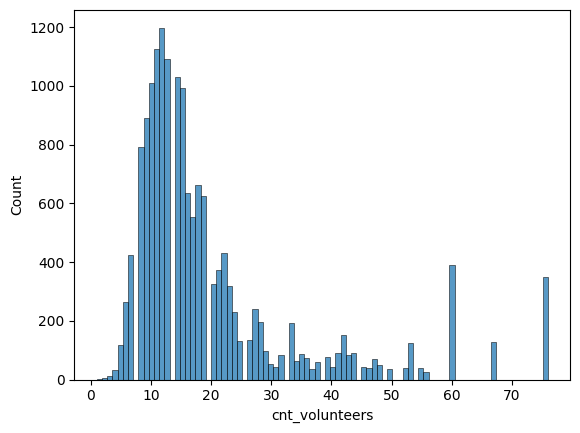

In [10]:
sns.histplot(num_col_starts.cnt_volunteers)

In [11]:
num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure','cnt_volunteers'
])
X = num_col_logit
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.657803
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16488
Model:                          Logit   Df Residuals:                    16462
Method:                           MLE   Df Model:                           25
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.04906
Time:                        11:38:18   Log-Likelihood:                -10846.
converged:                       True   LL-Null:                       -11405.
Covariance Type:            nonrobust   LLR p-value:                2.841e-220
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.0140      0.166      6

In [12]:
num_col_logit = num_col_starts.drop(columns=['is_repeated', 'record_id', 'athlete_id', 'is_newbie', 'snow.1h', 'rain.1h',  'feels_like',
        'humidity','clouds', 'wind_speed', 'wind_deg', 'dew_point', 'pressure'
])
for volonteri in range(10, 80, 10):
    X = num_col_logit[(num_col_logit.cnt_volunteers > volonteri-10) & (num_col_logit.cnt_volunteers <= volonteri)]
    y = num_col_starts[(num_col_starts.cnt_volunteers > volonteri-10) & (num_col_starts.cnt_volunteers <= volonteri)]['is_repeated']   
    print(F'ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: {volonteri-10+1} -- {volonteri}')
    try:
        X = sm.add_constant(X)
        model = sm.Logit(y, X).fit()
        print(model.summary())
        print('\n' * 2)
    except Exception:
        print('ошибка')
        #print(X.head(2))
        #print(y.value_counts())
        print('\n' * 2)

        



ПРОМЕЖУТОК КОЛ-ВА ВОЛОНТЕРОВ: 1 -- 10
Optimization terminated successfully.
         Current function value: 0.660395
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3546
Model:                          Logit   Df Residuals:                     3519
Method:                           MLE   Df Model:                           26
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.03445
Time:                        11:38:18   Log-Likelihood:                -2341.8
converged:                       True   LL-Null:                       -2425.3
Covariance Type:            nonrobust   LLR p-value:                 1.458e-22
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                   

In [13]:

#num_col['cnt_volunteers'] = num_col_starts.iloc[:, 17:39].sum(axis=1)
num_col.head(3)
num_col_starts = num_col.copy()


In [14]:
X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = num_col_starts['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

#но у нас потенциально discomfort_index не линейно влияет на is_repeated, тк слишком низкий и слишком высокий discomfort_index должен понижать is_repeated, а по серединке идеально и будет повышать..
#... is repeated.

Optimization terminated successfully.
         Current function value: 0.665829
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16488
Model:                          Logit   Df Residuals:                    16482
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.03746
Time:                        11:38:18   Log-Likelihood:                -10978.
converged:                       True   LL-Null:                       -11405.
Covariance Type:            nonrobust   LLR p-value:                1.870e-182
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5462      0.108      5.059      0.000       0.335       0.758
cnt_volunte

In [15]:
# поэтому попробую полиномиальные признаки сделать

from sklearn.preprocessing import PolynomialFeatures  

X = num_col_starts[['cnt_volunteers', 'discomfort_index', 'athlete_age', 'finish_time', 'is_male']]  
y = num_col_starts['is_repeated']  

# Создаем полиномиальные признаки  
poly = PolynomialFeatures(degree=2, include_bias=False)  
X_poly = poly.fit_transform(X)  

# Получаем имена новых признаков  
feature_names = poly.get_feature_names_out(input_features=X.columns)  

# Создаем DataFrame с новыми признаками  
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)  

# Устанавливаем индексы для X_poly_df, чтобы они совпадали с y  
X_poly_df.index = y.index  

# Добавляем константу  
X_poly_df = sm.add_constant(X_poly_df)  

# Обучаем логистическую регрессию  
model = sm.Logit(y, X_poly_df).fit()  

# Выводим результаты  
print(model.summary())  


Optimization terminated successfully.
         Current function value: 0.656611
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                16488
Model:                          Logit   Df Residuals:                    16468
Method:                           MLE   Df Model:                           19
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.05079
Time:                        11:38:19   Log-Likelihood:                -10826.
converged:                       True   LL-Null:                       -11405.
Covariance Type:            nonrobust   LLR p-value:                7.240e-234
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -1.3715      0.517     -2.654  

Теперь будем создавать модель не просто на всех данных, а по кластерам (Маргарита их сделала)

In [16]:
clst_1 = ['Архангельская область',
 'Архангельская область без автономного округа',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Ивановская область',
 'Калининградская область',
 'Калужская область',
 'Кировская область',
 'Костромская область',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Новгородская область',
 'Омская область',
 'Оренбургская область',
 'Орловская область',
 'Пензенская область',
 'Псковская область',
 'Республика Карелия',
 'Республика Коми',
 'Республика Крым',
 'Республика Марий Эл',
 'Республика Мордовия',
 'Рязанская область',
 'Саратовская область',
 'Смоленская область',
 'Ставропольский край',
 'Тамбовская область',
 'Тверская область',
 'Томская область',
 'Тульская область',
 'Удмуртская Республика',
 'Ульяновская область',
 'Чувашская Республика',
 'Ярославская область']


for_clst_1 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_1)]
X = for_clst_1[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_1['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.670836
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 3833
Model:                          Logit   Df Residuals:                     3827
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.01661
Time:                        11:38:19   Log-Likelihood:                -2571.3
converged:                       True   LL-Null:                       -2614.7
Covariance Type:            nonrobust   LLR p-value:                 3.070e-17
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.7346      0.234      3.144      0.002       0.277       1.193
cnt_volunte

In [17]:
# ВТОРОЙ КЛАСТЕР
clst_2 = ['Алтайский край',
 'Иркутская область',
 'Кемеровская область',
 'Краснодарский край',
 'Красноярский край',
 'Нижегородская область',
 'Новосибирская область',
 'Пермский край',
 'Приморский край',
 'Республика Башкортостан',
 'Республика Татарстан',
 'Ростовская область',
 'Самарская область',
 'Свердловская область',
 'Тюменская область',
 'Челябинская область']

for_clst_2 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_2)]
X = for_clst_2[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_2['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.650220
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 6543
Model:                          Logit   Df Residuals:                     6537
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.06141
Time:                        11:38:19   Log-Likelihood:                -4254.4
converged:                       True   LL-Null:                       -4532.8
Covariance Type:            nonrobust   LLR p-value:                4.497e-118
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8219      0.174      4.721      0.000       0.481       1.163
cnt_volunte

In [18]:
# ТРЕТИЙ КЛАСТЕР
clst_3 = ['Амурская область',
 'Астраханская область',
 'Еврейская автономная область',
 'Забайкальский край',
 'Кабардино-Балкарская Республика',
 'Камчатский край',
 'Карачаево-Черкесская Республика',
 'Магаданская область',
 'Мурманская область',
 'Республика Адыгея',
 'Республика Алтай',
 'Республика Бурятия',
 'Республика Калмыкия',
 'Республика Саха (Якутия)',
 'Республика Северная Осетия — Алания',
 'Республика Тыва',
 'Республика Хакасия',
 'Сахалинская область',
 'Севастополь',
 'Тюменская область без автономных округов',
 'Хабаровский край',
 'Ханты-Мансийский автономный округ — Югра']
for_clst_3 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_3)]
X = for_clst_3[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_3['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.584128
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.1489
Time:                        11:38:19   Log-Likelihood:                -185.17
converged:                       True   LL-Null:                       -217.56
Covariance Type:            nonrobust   LLR p-value:                 1.239e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8222      0.887      0.927      0.354      -0.916       2.560
cnt_volunte

In [19]:
# ЧЕТВЕРТЫЙ КЛАСТЕР
# clst_4 = ['Республика Дагестан', 'Республика Ингушетия', 'Чеченская Республика']
# for_clst_4 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_4)]
# X = for_clst_4[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
# y = for_clst_4['is_repeated']   
# X = sm.add_constant(X)
# model = sm.Logit(y, X).fit()
# print(model.summary())

#В ЭТИХ РЕГИОНОВ ВООБЩЕ НЕТ 5 ВЕРСТ

In [20]:
# # 5 кластер
# clst_5 = ['Ненецкий автономный округ',
#  'Чукотский автономный округ',
#  'Ямало-Ненецкий автономный округ']

# for_clst_5 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_5)]
# X = for_clst_5[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
# y = for_clst_5['is_repeated']   
# X = sm.add_constant(X)
# model = sm.Logit(y, X).fit()
# print(model.summary())


# #ТОЖЕ НЕТ ТАКИХ РЕГИОНОВ В 5 ВЕРСТ

In [21]:
clst_6 = ['Москва', 'Московская область', 'Санкт-Петербург']
for_clst_6 = come_with_didnt_come[come_with_didnt_come.region.isin(clst_6)]
X = for_clst_6[['cnt_volunteers', 'discomfort_index', 'athlete_age','finish_time','is_male']]
y = for_clst_6['is_repeated']   
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.677006
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5795
Model:                          Logit   Df Residuals:                     5789
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                 0.01746
Time:                        11:38:19   Log-Likelihood:                -3923.2
converged:                       True   LL-Null:                       -3993.0
Covariance Type:            nonrobust   LLR p-value:                 2.340e-28
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0880      0.194      0.453      0.651      -0.293       0.469
cnt_volunte

Если выше я работал с отдельными новичками и предсказываением придет ли он во 2 раз или нет, то щас будет уже работа  с отдельной пробежкой и сколько человек после нее придет/не придет

In [22]:
cnt_ludei = starts.groupby(['event_name', 'event_date']).agg(
    cnt_runners = ('athlete_id', 'count'),
    region = ('region', 'last'),
    discomfort_index = ('discomfort_index','last')
)

info_about_jogging = first_runs.groupby(['event_name', 'event_date', 'region']).agg(
    pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 1])),
    ne_pridut = ('athlete_id', lambda x: len(x[first_runs['is_repeated'] == 0])),
    vsego_newbie = ('athlete_id', 'count'), 
    mean_age = ('athlete_age', 'mean'),
    mean_finish_time = ('finish_time', 'mean'),
    mean_gender =('is_male', lambda x: x.sum() / len(x))        #чем ближе к 1 - тем больше мужчин на пробежке было

).reset_index()
info_about_jogging = info_about_jogging.merge(cnt_ludei, on=['event_date', 'event_name', 'region'], how='left')
info_about_jogging = info_about_jogging.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

info_about_jogging = info_about_jogging.fillna(0)
info_about_jogging['otnos_ne_pridut'] = info_about_jogging['ne_pridut'] / info_about_jogging['vsego_newbie']

print(len(info_about_jogging))
info_about_jogging['cnt_volunteers'] = info_about_jogging.iloc[:, 10:37].sum(axis=1)

display(info_about_jogging.head(5))


3624


,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_finish_time,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
0,Александрино,2023-04-08,Санкт-Петербург,9,7,16,40.500000,2180.625000,0.500000,81,6.28660,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,2,1,0,0,0,2,0,0.437500,17.28660
1,Александрино,2023-04-15,Санкт-Петербург,5,4,9,41.555556,1826.222222,0.444444,20,6.67771,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.444444,16.67771
2,Александрино,2023-04-22,Санкт-Петербург,4,2,6,34.666667,1670.166667,0.500000,15,11.58912,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,19.58912
3,Александрино,2023-04-29,Санкт-Петербург,6,1,7,43.571429,2029.142857,0.428571,22,6.01066,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.142857,14.01066
4,Александрино,2023-05-06,Санкт-Петербург,4,2,6,39.500000,2014.333333,0.500000,26,7.70362,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,0,0.333333,15.70362


In [23]:
numeric_jogging = info_about_jogging[(info_about_jogging['vsego_newbie'] <= 7)&(info_about_jogging['vsego_newbie'] >= 3)].select_dtypes(include='number')
correlation = numeric_jogging.corr(method="spearman")['otnos_ne_pridut']
correlation

pridut                              -0.817816
ne_pridut                            0.901997
vsego_newbie                         0.050852
mean_age                            -0.120102
mean_finish_time                     0.004994
mean_gender                         -0.050082
cnt_runners                          0.001446
discomfort_index                     0.078377
Ведущий велосипед                    0.003209
Завершение мероприятия               0.005898
Замыкающий                           0.053706
Инструктаж новых участников          0.009906
Координатор парковки                -0.008412
Координация волонтёров              -0.010725
Лидер для слабовидящих               0.016020
Маршал                               0.028126
Обработка результатов               -0.017011
Организатор                          0.025881
Организация финиша                   0.022904
Пейсер                               0.025159
Подготовка мероприятия              -0.007942
Помощь в раздаче карточек позиций 

count    3624.000000
mean        4.549669
std        10.410231
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       363.000000
Name: vsego_newbie, dtype: float64


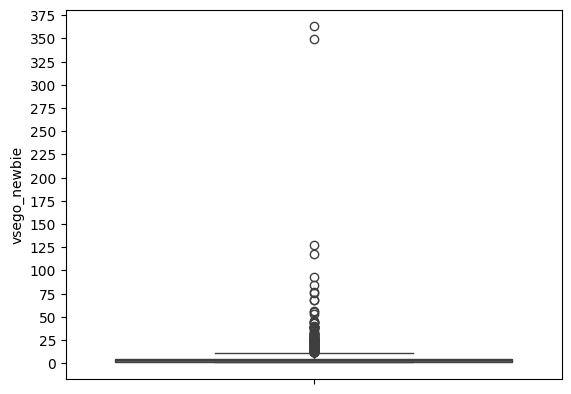

In [24]:
plt.yticks([i for i in range(0, 400, 25)])
sns.boxplot(y=info_about_jogging.vsego_newbie)
print(info_about_jogging.vsego_newbie.describe())


Text(0.5, 1.0, 'Распределение кол-ва волонтеров на пробежке')

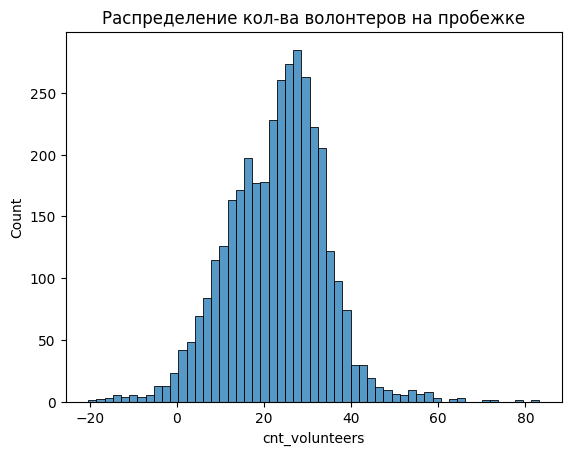

In [25]:
sns.histplot(x=info_about_jogging.cnt_volunteers)
plt.title('Распределение кол-ва волонтеров на пробежке')

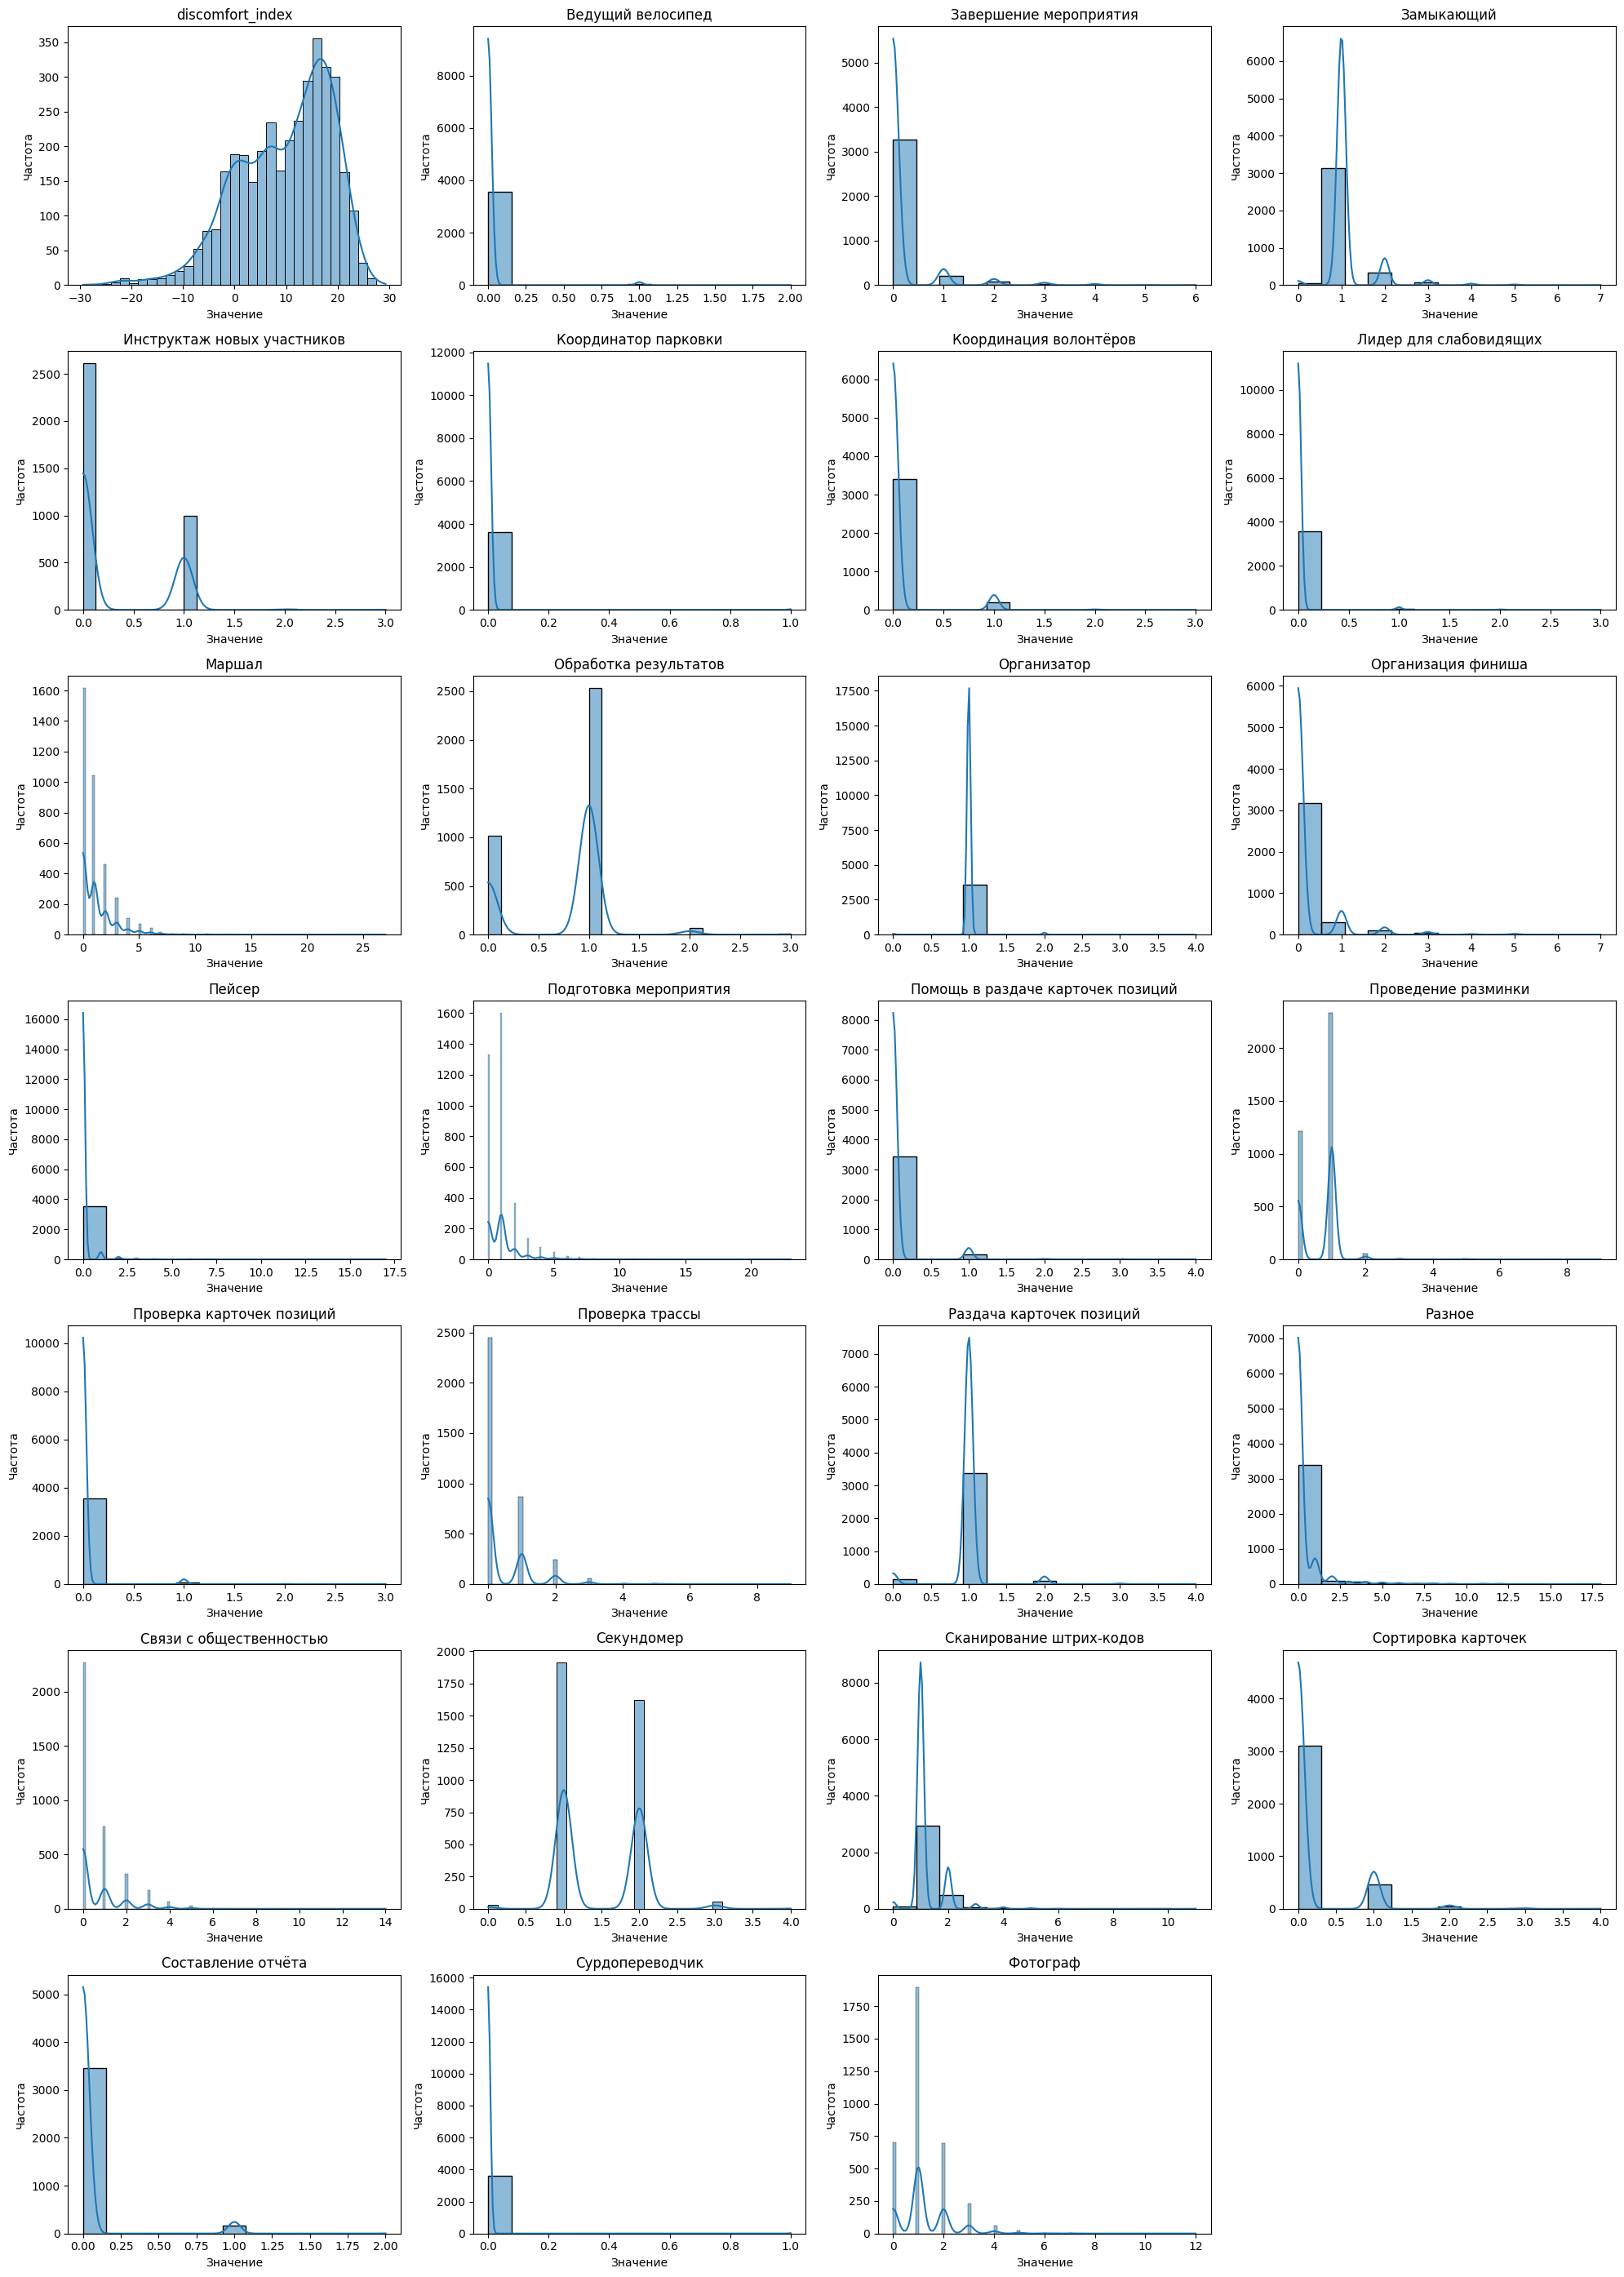

In [26]:
vol_roles = info_about_jogging.iloc[:,10:37]
n_cols = 4  # Число столбцов в сетке  
n_rows = (len(vol_roles.columns) + n_cols - 1) // n_cols  # Число строк в сетке  

plt.figure(figsize=(20, n_rows * 4))  # Устанавливаем размер графиков  

# Генерируем мотивационные графики  
for i, column in enumerate(vol_roles.columns):  
    plt.subplot(n_rows, n_cols, i + 1)  # Установка позиции подграфика  
    sns.histplot(vol_roles[column], kde=True, )  # gистограмма с KDE (оценка плотности)  
    plt.title(column)  # Заголовок графика  
    
    plt.xlabel('Значение')  # Подпись оси X  
    plt.ylabel('Частота')  # Подпись оси Y  
    

plt.tight_layout()  # Оптимизация пространства между подграфиками  
plt.show()  # Отображение графиков 

In [69]:
info_about_jogging[info_about_jogging['Ведущий велосипед'] > 0].head(10)

,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,otnos_pridut,cnt_volunteers
1354,Магнитогорск Экопарк,2023-06-10,Челябинская область,10,5,15,35.600000,0.666667,101,14.70763,1,0,1,0,0,0,0,5,1,1,1,2,1,2,1,0,0,1,2,0,1,2,0,1,0,3,0,0.333333,0.666667,26
2037,Парк Горького,2023-09-16,Москва,19,66,85,36.505882,0.564706,338,11.51935,1,0,2,0,0,0,0,5,1,1,0,0,3,3,1,0,0,1,1,1,2,5,0,0,0,5,1,0.776471,0.223529,33
2735,Солнечный остров,2023-06-10,Краснодарский край,11,8,19,36.526316,0.473684,81,20.16088,1,0,2,3,0,0,0,1,1,1,0,4,7,1,1,0,0,1,0,1,2,2,3,0,0,2,1,0.421053,0.578947,34
3193,Чебоксары набережная,2023-08-05,Чувашская Республика,1,8,9,29.000000,0.444444,23,24.06080,1,0,1,0,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.888889,0.111111,11
3290,Швейцария,2023-08-05,Нижегородская область,5,4,9,38.555556,0.333333,28,22.24865,2,0,1,1,0,0,0,1,1,1,2,0,1,1,1,0,3,1,1,2,2,1,1,0,0,4,1,0.444444,0.555556,28
3312,Якутск Дохсун,2023-04-29,Республика Саха (Якутия),4,51,55,35.909091,0.454545,76,6.46520,1,0,2,1,0,1,0,2,0,1,0,0,4,0,1,0,1,1,0,0,2,2,0,0,0,3,0,0.927273,0.072727,22
3325,Якутск Дохсун,2023-07-29,Республика Саха (Якутия),2,5,7,39.285714,0.571429,40,19.50536,1,1,1,0,0,0,0,3,1,1,0,0,2,1,1,0,0,1,1,0,2,2,0,0,0,1,0,0.714286,0.285714,19


In [70]:
info_about_jogging['otnos_pridut'] = 1 - info_about_jogging['otnos_ne_pridut']

Text(0.5, 0, 'Количество новичков')

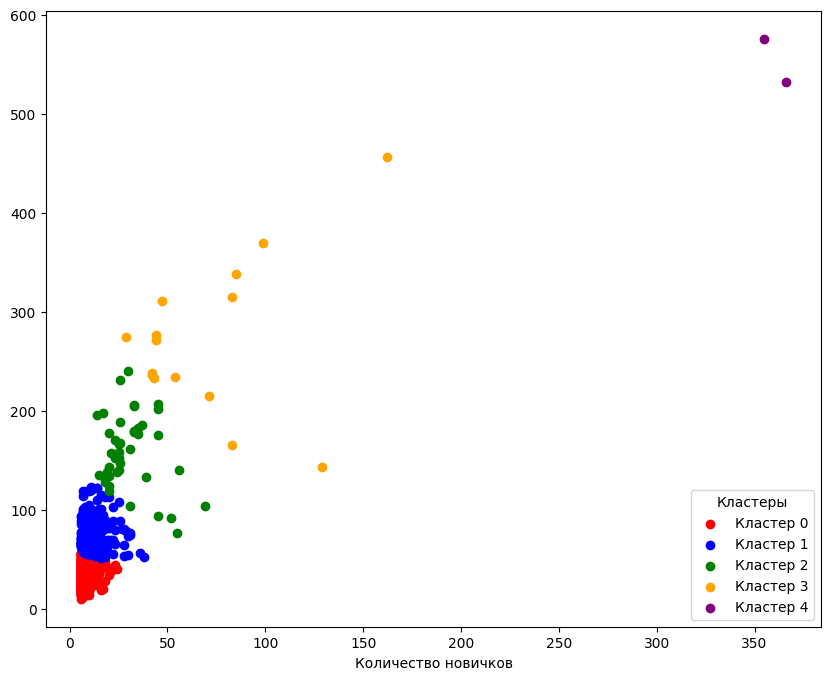

In [92]:
k = 5
plt.figure(figsize=(10, 8))
# Применяем K-Means
kmeans = KMeans(n_clusters=k, random_state=42)
info_about_jogging['kmeans_cluster'] = kmeans.fit_predict(data_scaled)
# Находим средние значения cnt_runners для каждого кластера
cluster_order = (
    info_about_jogging.groupby('kmeans_cluster')['cnt_runners']
    .mean()
    .sort_values()
    .reset_index()
)

# Создаем новый столбец с перенумерованными кластерами
cluster_mapping = {old: new for new, old in enumerate(cluster_order['kmeans_cluster'])}
info_about_jogging['kmeans_cluster_renumbered'] = info_about_jogging['kmeans_cluster'].map(cluster_mapping)

# Визуализация с новой нумерацией кластеров
colors = ['red', 'blue', 'green', 'orange', 'purple']  # Цвета для кластеров
for cluster_id, color in enumerate(colors):
    cluster_data = info_about_jogging[info_about_jogging['kmeans_cluster_renumbered'] == cluster_id]
    plt.scatter(cluster_data['vsego_newbie'], cluster_data['cnt_runners'], c=color, label=f'Кластер {cluster_id}')

# Легенда и подписи
plt.legend(title='Кластеры', loc='lower right')
plt.xlabel('Количество новичков')


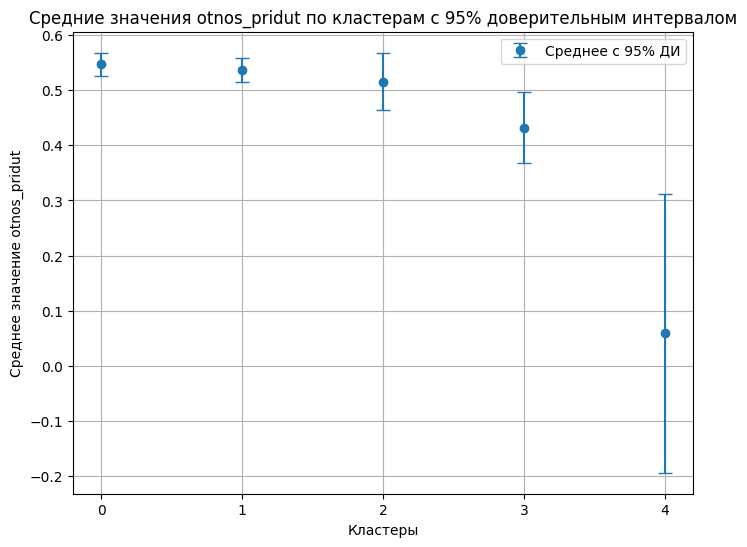

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem, t

# Подготовьте данные, например:
# info_about_jogging = pd.read_csv('path_to_file.csv')

# Группируем данные по кластерам
grouped = info_about_jogging.groupby('kmeans_cluster_renumbered')['otnos_pridut']

# Вычисляем средние и доверительные интервалы
means = grouped.mean()
counts = grouped.count()
std_errors = grouped.apply(sem)

# 95% доверительный интервал
confidence_intervals = std_errors * t.ppf((1 + 0.95) / 2, counts - 1)

# Создаем DataFrame для визуализации
ci_data = pd.DataFrame({
    'Cluster': means.index,
    'Mean': means.values,
    'CI_lower': means.values - confidence_intervals.values,
    'CI_upper': means.values + confidence_intervals.values
})

# Построение графика
plt.figure(figsize=(8, 6))
plt.errorbar(ci_data['Cluster'], ci_data['Mean'], 
             yerr=[ci_data['Mean'] - ci_data['CI_lower'], ci_data['CI_upper'] - ci_data['Mean']],
             fmt='o', capsize=5, label='Среднее с 95% ДИ')
plt.xticks(ci_data['Cluster'])
plt.xlabel('Кластеры')
plt.ylabel('Среднее значение')
plt.title('Средние значения otnos_pridut по кластерам с 95% доверительным интервалом')
plt.legend()
plt.grid()
plt.show()


In [94]:
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Предположим, у вас есть DataFrame info_about_jogging
# Группируем данные по кластерам
grouped = info_about_jogging.groupby('kmeans_cluster_renumbered')

# Создаем таблицу частот
cluster_data = grouped.agg(
    success=('otnos_pridut', 'sum'), 
    total=('otnos_pridut', 'count')
)
cluster_data['failure'] = cluster_data['total'] - cluster_data['success']

# Попарные комбинации кластеров
pairs = list(combinations(cluster_data.index, 2))
p_values = []
comparisons = []

for g1, g2 in pairs:
    # Создаем таблицу для теста Фишера
    contingency_table = [
        [cluster_data.loc[g1, 'success'], cluster_data.loc[g1, 'failure']],
        [cluster_data.loc[g2, 'success'], cluster_data.loc[g2, 'failure']]
    ]

    _, p_val = fisher_exact(contingency_table)
    p_values.append(p_val)
    comparisons.append(f"{g1} vs {g2}")

# Корректируем p-value методом Бонферрони
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Формируем DataFrame с результатами
results = pd.DataFrame({
    'Comparison': comparisons,
    'P-Value': p_values,
    'Corrected P-Value': pvals_corrected,
    'Significant': reject
})

# Сохранение результатов
print(results)


  Comparison   P-Value  Corrected P-Value  Significant
0     0 vs 1  0.820520                1.0        False
1     0 vs 2  0.744558                1.0        False
2     0 vs 3  0.423746                1.0        False
3     0 vs 4  0.454167                1.0        False
4     1 vs 2  0.867019                1.0        False
5     1 vs 3  0.584607                1.0        False
6     1 vs 4  0.464029                1.0        False
7     2 vs 3  0.758481                1.0        False
8     2 vs 4  1.000000                1.0        False
9     3 vs 4  1.000000                1.0        False


<Axes: xlabel='otnos_pridut', ylabel='Count'>

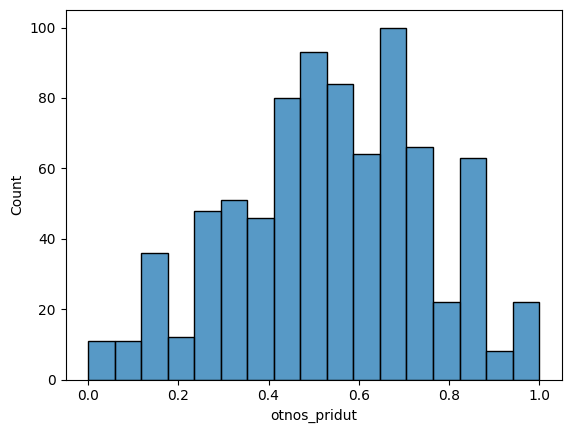

In [136]:
sns.histplot(info_about_jogging.otnos_pridut)

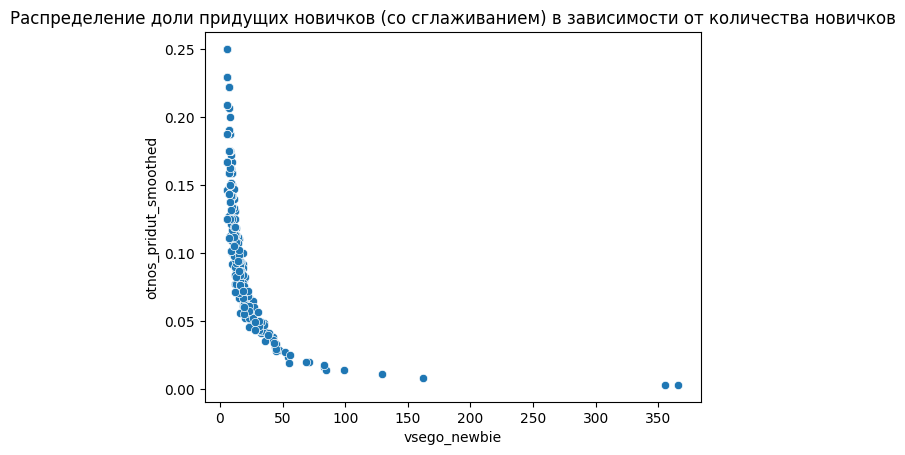

In [74]:

alpha = 1
beta = 1

info_about_jogging['otnos_pridut_smoothed'] = (
    (info_about_jogging['otnos_pridut'] + alpha) / 
    (info_about_jogging['vsego_newbie'] + alpha + beta)
)


sns.scatterplot(
    y=info_about_jogging.otnos_pridut_smoothed, 
    x=info_about_jogging.vsego_newbie
)
plt.title('Распределение доли придущих новичков (со сглаживанием) в зависимости от количества новичков')
plt.show()


C:\Users\Semyon\AppData\Local\Temp\ipykernel_11072\1071512558.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = (filtered_data


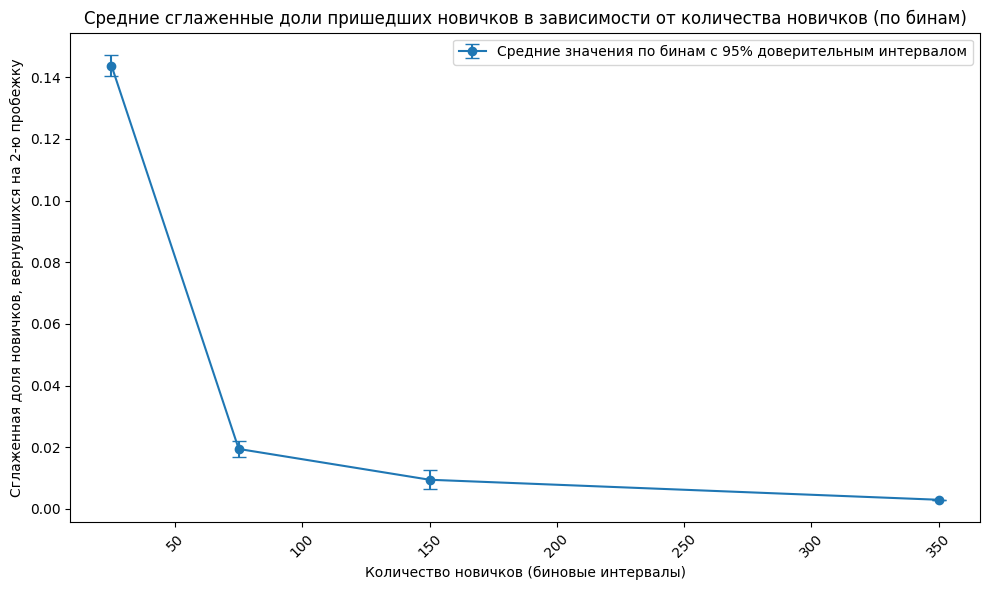

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


alpha = 1
beta = 1

info_about_jogging['otnos_pridut_smoothed'] = (
    (info_about_jogging['otnos_pridut'] + alpha) / 
    (info_about_jogging['vsego_newbie'] + alpha + beta)
)


filtered_data = info_about_jogging


bin_edges = [0, 50, 100, 200, 500]
filtered_data['vsego_newbie_bin'] = pd.cut(filtered_data['vsego_newbie'], bins=bin_edges)

aggregated = (filtered_data
              .groupby('vsego_newbie_bin')['otnos_pridut_smoothed']
              .agg(['mean', 'std', 'count'])
              .reset_index())

z = 1.96 
aggregated['ci'] = z * aggregated['std'] / np.sqrt(aggregated['count'])

bin_centers = aggregated['vsego_newbie_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(10,6))
plt.errorbar(
    bin_centers, 
    aggregated['mean'], 
    yerr=aggregated['ci'], 
    fmt='o-', 
    capsize=5, 
    label='Средние значения по бинам с 95% доверительным интервалом'
)

plt.title('Средние сглаженные доли пришедших новичков в зависимости от количества новичков (по бинам)')
plt.xlabel('Количество новичков (биновые интервалы)')
plt.ylabel('Сглаженная доля новичков, вернувшихся на 2-ю пробежку')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
from itertools import combinations
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Предполагается, что filtered_data уже определён
# filtered_data = pd.read_csv('path_to_your_data.csv')

# Подготовка данных для попарных сравнений
filtered_data['success'] = filtered_data['otnos_pridut_smoothed'] * filtered_data['vsego_newbie']
filtered_data['failure'] = filtered_data['vsego_newbie'] - filtered_data['success']

# Группировка данных по бинам
aggregated_bins = filtered_data.groupby('vsego_newbie_bin').agg(
    success=('success', 'sum'),
    failure=('failure', 'sum')
).reset_index()

# Попарные комбинации бинов
pairs = list(combinations(aggregated_bins['vsego_newbie_bin'], 2))
p_values = []
comparisons = []

for bin1, bin2 in pairs:
    row1 = aggregated_bins[aggregated_bins['vsego_newbie_bin'] == bin1]
    row2 = aggregated_bins[aggregated_bins['vsego_newbie_bin'] == bin2]
    
    contingency_table = [
        [row1['success'].values[0], row1['failure'].values[0]],
        [row2['success'].values[0], row2['failure'].values[0]]
    ]
    
    _, p_val = fisher_exact(contingency_table)
    p_values.append(p_val)
    comparisons.append(f"{bin1} vs {bin2}")

# Корректировка p-value методом Бонферрони
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Создание DataFrame с результатами
results = pd.DataFrame({
    'Comparison': comparisons,
    'P-Value': p_values,
    'Corrected P-Value': pvals_corrected,
    'Significant': reject
})

# Вывод результатов
print(results)


                 Comparison       P-Value  Corrected P-Value  Significant
0      (0, 50] vs (50, 100]  4.341148e-22       2.604689e-21         True
1     (0, 50] vs (100, 200]  3.376922e-13       2.026153e-12         True
2     (0, 50] vs (200, 500]  1.021731e-34       6.130388e-34         True
3   (50, 100] vs (100, 200]  2.539579e-01       1.000000e+00        False
4   (50, 100] vs (200, 500]  3.696008e-03       2.217605e-02         True
5  (100, 200] vs (200, 500]  3.255534e-01       1.000000e+00        False


C:\Users\Semyon\AppData\Local\Temp\ipykernel_11072\2826483260.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_bins = filtered_data.groupby('vsego_newbie_bin').agg(


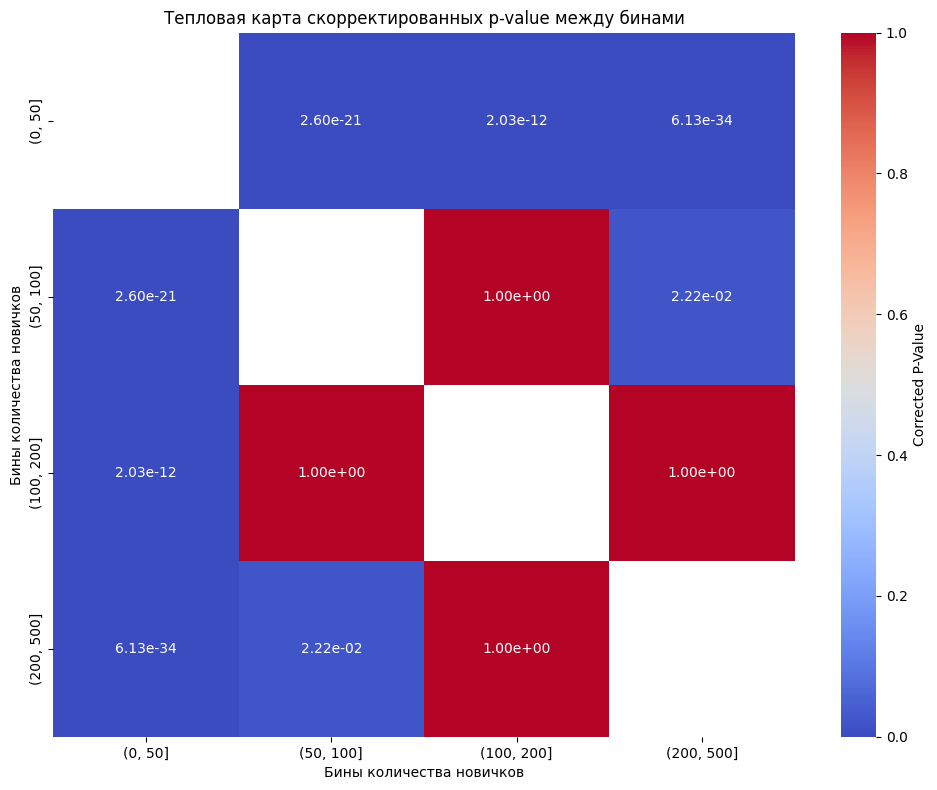

In [99]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Убедитесь, что aggregated_bins и pvals_corrected определены

# Создание матрицы для тепловой карты
bins = aggregated_bins['vsego_newbie_bin'].unique()
heatmap_matrix = np.ones((len(bins), len(bins))) * np.nan

# Заполняем матрицу значениями скорректированных p-value
bin_to_idx = {bin_: idx for idx, bin_ in enumerate(bins)}
for (bin1, bin2), p_val in zip(pairs, pvals_corrected):
    i, j = bin_to_idx[bin1], bin_to_idx[bin2]
    heatmap_matrix[i, j] = p_val
    heatmap_matrix[j, i] = p_val  # Симметрия

# Преобразуем в DataFrame для удобства
heatmap_df = pd.DataFrame(heatmap_matrix, index=bins, columns=bins)

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".2e",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrected P-Value'},
    mask=np.isnan(heatmap_matrix)  # Скрываем пустые ячейки
)
plt.title('Тепловая карта скорректированных p-value между бинами')
plt.xlabel('Бины количества новичков')
plt.ylabel('Бины количества новичков')
plt.tight_layout()
plt.show()


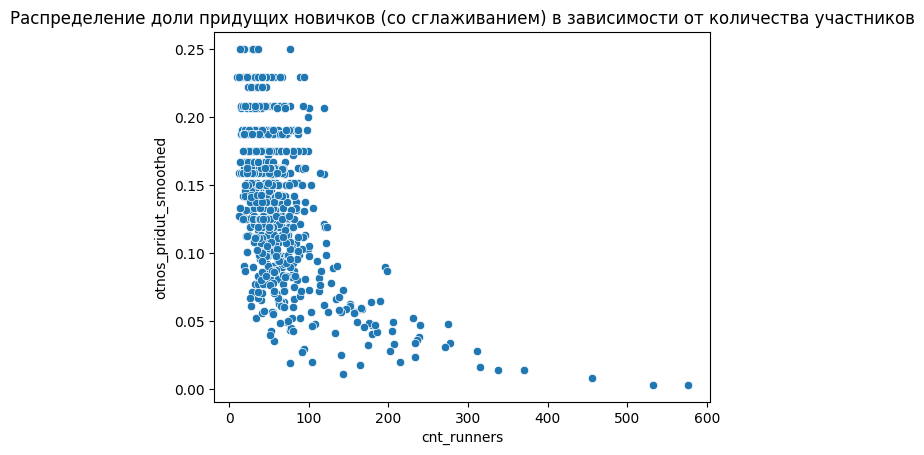

In [71]:

alpha = 1
beta = 1

info_about_jogging['otnos_pridut_smoothed'] = (
    (info_about_jogging['otnos_pridut'] + alpha) / 
    (info_about_jogging['vsego_newbie'] + alpha + beta)
)


sns.scatterplot(
    y=info_about_jogging[info_about_jogging['vsego_newbie'] > 3].otnos_pridut_smoothed, 
    x=info_about_jogging.cnt_runners
)
plt.title('Распределение доли придущих новичков (со сглаживанием) в зависимости от количества участников')
plt.show()


C:\Users\Semyon\AppData\Local\Temp\ipykernel_15052\2625725110.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = (filtered_data


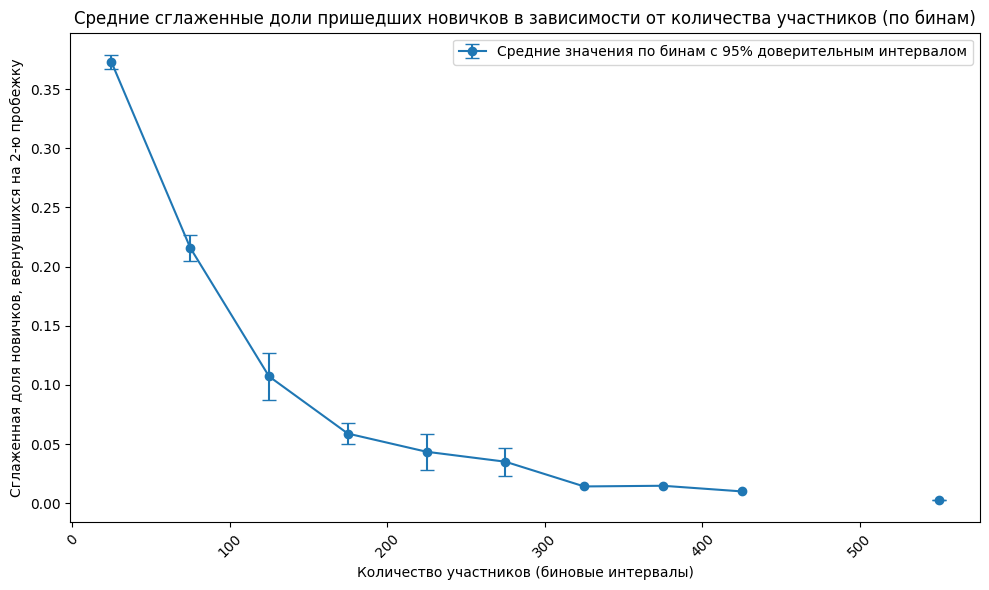

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


alpha = 1
beta = 1

info_about_jogging['otnos_pridut_smoothed'] = (
    (info_about_jogging['otnos_pridut'] + alpha) / 
    (info_about_jogging['vsego_newbie'] + alpha + beta)
)


filtered_data = info_about_jogging


bin_edges = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600]
filtered_data['cnt_runners_bin'] = pd.cut(filtered_data['cnt_runners'], bins=bin_edges)

aggregated = (filtered_data
              .groupby('cnt_runners_bin')['otnos_pridut_smoothed']
              .agg(['mean', 'std', 'count'])
              .reset_index())

z = 1.96 
aggregated['ci'] = z * aggregated['std'] / np.sqrt(aggregated['count'])

bin_centers = aggregated['cnt_runners_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(10,6))
plt.errorbar(
    bin_centers, 
    aggregated['mean'], 
    yerr=aggregated['ci'], 
    fmt='o-', 
    capsize=5, 
    label='Средние значения по бинам с 95% доверительным интервалом'
)

plt.title('Средние сглаженные доли пришедших новичков в зависимости от количества участников (по бинам)')
plt.xlabel('Количество участников (биновые интервалы)')
plt.ylabel('Сглаженная доля новичков, вернувшихся на 2-ю пробежку')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
info_about_jogging['cnt_runners'].corr(info_about_jogging['vsego_newbie'], method='spearman')

0.6123678766729324

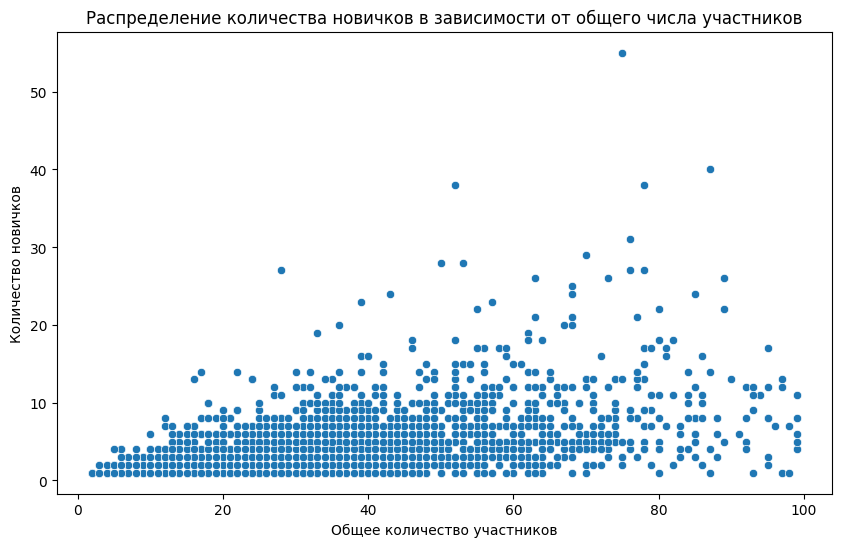

In [65]:


plt.figure(figsize=(10,6))
sns.scatterplot(data=info_about_jogging[info_about_jogging['cnt_runners'] < 100], x='cnt_runners', y='vsego_newbie')
plt.title('Распределение количества новичков в зависимости от общего числа участников')
plt.xlabel('Общее количество участников')
plt.ylabel('Количество новичков')
plt.show()


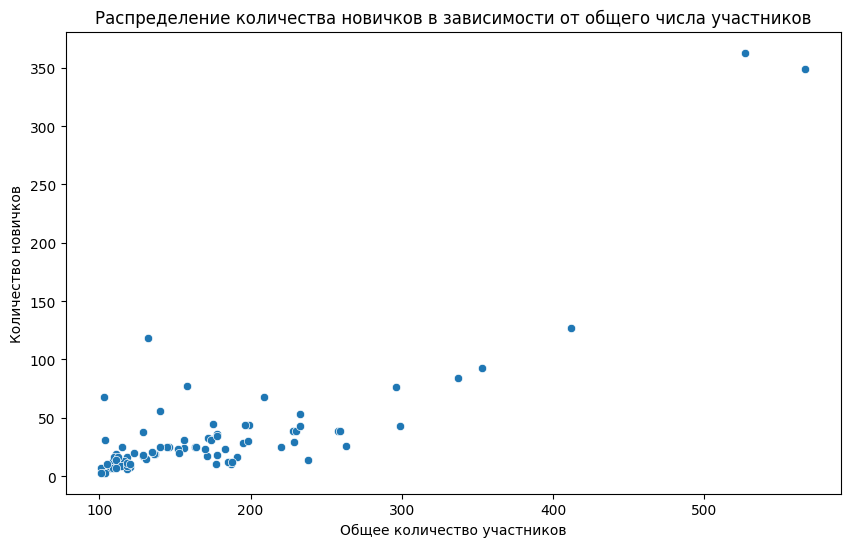

In [66]:


plt.figure(figsize=(10,6))
sns.scatterplot(data=info_about_jogging[info_about_jogging['cnt_runners'] > 100], x='cnt_runners', y='vsego_newbie')
plt.title('Распределение количества новичков в зависимости от общего числа участников')
plt.xlabel('Общее количество участников')
plt.ylabel('Количество новичков')
plt.show()

Text(0.5, 1.0, 'Распределение доли придущих новичков на 2 пробежку в зависимости от количества участников')

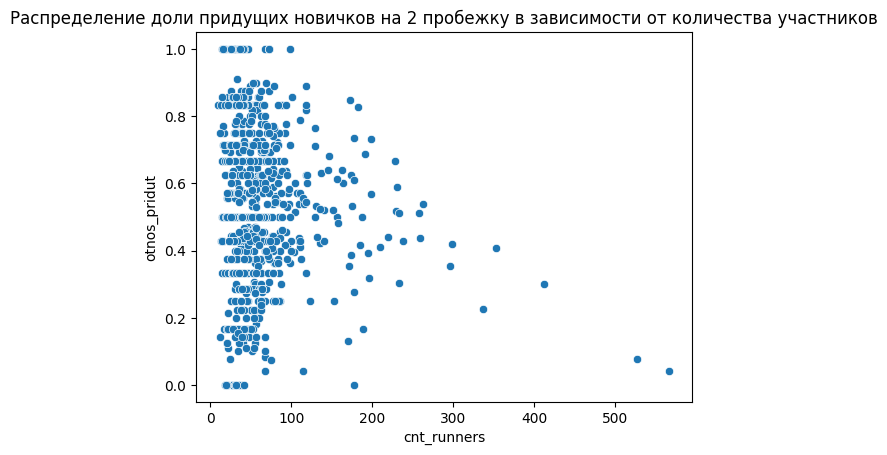

In [42]:
sns.scatterplot(y=info_about_jogging[info_about_jogging.vsego_newbie > 5].otnos_pridut, x=info_about_jogging.cnt_runners)
plt.title('Распределение доли придущих новичков на 2 пробежку в зависимости от количества участников')

In [82]:
bin_edges = [0, 50, 100, 200, 500, 600]
info_about_jogging['cnt_runners_bin'] = pd.cut(info_about_jogging['cnt_runners'], bins=bin_edges)

aggregated = (info_about_jogging
              .groupby('cnt_runners_bin')
              .agg(newbies_count=('vsego_newbie','sum'),
                   total_count=('cnt_runners','sum'))
              .reset_index())


C:\Users\Semyon\AppData\Local\Temp\ipykernel_15052\840135122.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = (info_about_jogging


In [83]:
from scipy.stats import fisher_exact
from itertools import combinations
from statsmodels.stats.multitest import multipletests

groups = aggregated['cnt_runners_bin'].unique()
pairs = list(combinations(groups, 2))

p_values = []
comparisons = []

for g1, g2 in pairs:
    row1 = aggregated.loc[aggregated['cnt_runners_bin'] == g1]
    row2 = aggregated.loc[aggregated['cnt_runners_bin'] == g2]

 
    newbies1 = row1['newbies_count'].values[0]
    total1 = row1['total_count'].values[0]
    not_newbies1 = total1 - newbies1


    newbies2 = row2['newbies_count'].values[0]
    total2 = row2['total_count'].values[0]
    not_newbies2 = total2 - newbies2

    contingency = [[newbies1, not_newbies1],
                   [newbies2, not_newbies2]]

    _, p_val = fisher_exact(contingency)
    p_values.append(p_val)
    comparisons.append((g1, g2))


reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

for (g1, g2), p_val, corr_p, rej in zip(comparisons, p_values, pvals_corrected, reject):
    print(f"Сравнение {g1} vs {g2}: p-value={p_val:.4f}, corrected p-value={corr_p:.4f}, significant={rej}")


Сравнение (0, 50] vs (50, 100]: p-value=0.0025, corrected p-value=0.0246, significant=True
Сравнение (0, 50] vs (100, 200]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (0, 50] vs (200, 500]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (0, 50] vs (500, 600]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (50, 100] vs (100, 200]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (50, 100] vs (200, 500]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (50, 100] vs (500, 600]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (100, 200] vs (200, 500]: p-value=0.0000, corrected p-value=0.0001, significant=True
Сравнение (100, 200] vs (500, 600]: p-value=0.0000, corrected p-value=0.0000, significant=True
Сравнение (200, 500] vs (500, 600]: p-value=0.0000, corrected p-value=0.0000, significant=True


<Axes: >

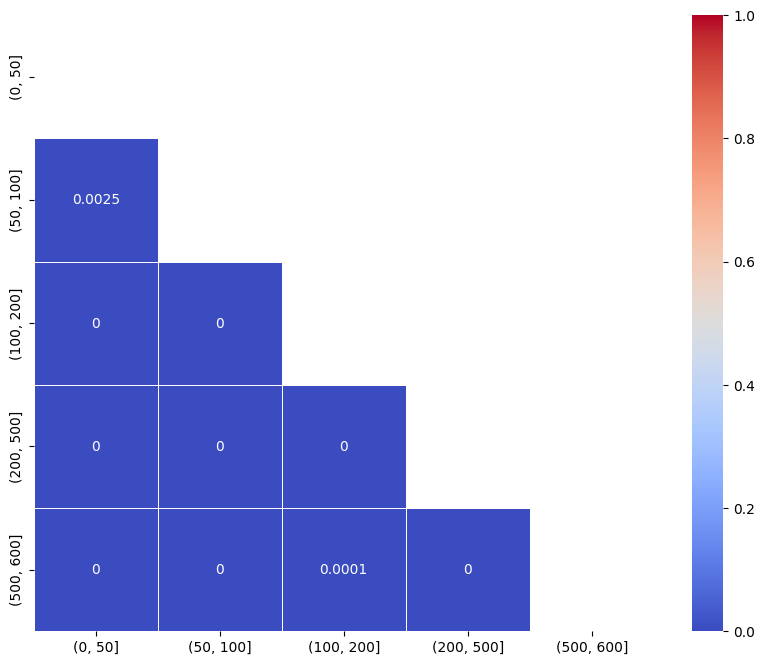

In [85]:

bins = ["(0, 50]", "(50, 100]", "(100, 200]", "(200, 500]", "(500, 600]"]

p_matrix = pd.DataFrame(np.nan, index=bins, columns=bins)




p_matrix.loc["(50, 100]", "(0, 50]"] = 0.0025

p_matrix.loc["(100, 200]", "(0, 50]"] = 0.0000

p_matrix.loc["(200, 500]", "(0, 50]"] = 0.0000

p_matrix.loc["(100, 200]", "(50, 100]"] = 0.0000

p_matrix.loc["(200, 500]", "(50, 100]"] = 0.0000

p_matrix.loc["(200, 500]", "(100, 200]"] = 0.0000
p_matrix.loc["(500, 600]", "(0, 50]"] = 0.0000
p_matrix.loc["(500, 600]", "(50, 100]"] = 0.0000
p_matrix.loc["(500, 600]", "(100, 200]"] = 0.0001
p_matrix.loc["(500, 600]", "(200, 500]"] = 0.0000


plt.figure(figsize=(10,8))
sns.heatmap(p_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1, linewidths=.5)


Text(0.5, 1.0, 'Распределение доли не придущих новичков на 2 пробежку')

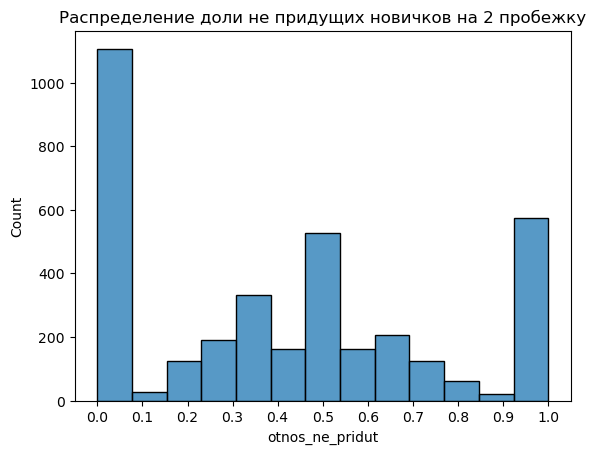

In [62]:
sns.histplot(x=info_about_jogging.otnos_ne_pridut)
plt.xticks([(i/10) for i in range(0, 11)])
plt.title('Распределение доли не придущих новичков на 2 пробежку')

In [ ]:
sns.scatterplot(x=info_about_jogging.otnos_ne_pridut)
plt.xticks([(i/10) for i in range(0, 11)])
plt.title('Распределение доли не придущих новичков на 2 пробежку')

In [199]:
info_about_jogging[info_about_jogging['otnos_ne_pridut']==0].head(10) 

,event_name,event_date,region,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,cnt_volunteers
10,Александрино,2023-06-17,Санкт-Петербург,2,0,2,53.0,1.0,19,19.629920,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,1,0,0.0,9
15,Александрино,2023-07-22,Санкт-Петербург,3,0,3,42.0,1.0,23,17.393320,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,12
17,Александрино,2023-08-05,Санкт-Петербург,2,0,2,38.5,0.5,26,19.321720,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,11
22,Александрино,2023-09-16,Санкт-Петербург,1,0,1,46.0,0.0,17,11.184320,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,0,2,1,0,0,1,1,0,0,0,1,0,0.0,10
24,Александрино,2023-09-30,Санкт-Петербург,1,0,1,31.0,1.0,22,15.732880,0,0,1,1,0,0,0,1,1,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.0,12
25,Александрино,2023-10-07,Санкт-Петербург,2,0,2,42.0,1.0,21,5.384980,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,2,0,0.0,12
28,Александрино,2023-11-11,Санкт-Петербург,2,0,2,39.5,0.5,29,6.154180,0,0,1,1,0,0,0,1,1,1,0,0,0,0,1,0,2,1,0,0,1,1,0,0,0,1,0,0.0,12
29,Бабушкинский на Яузе,2023-01-14,Москва,1,0,1,41.0,1.0,24,-2.219295,0,3,1,1,0,0,0,1,0,1,0,0,4,0,1,0,0,1,0,0,2,1,0,0,0,0,0,0.0,16
31,Бабушкинский на Яузе,2023-01-28,Москва,1,0,1,33.0,1.0,25,-2.741610,0,1,1,0,0,0,0,1,0,1,0,0,2,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0.0,10
33,Бабушкинский на Яузе,2023-02-18,Москва,1,0,1,40.0,1.0,29,-6.468300,0,2,1,1,0,0,0,1,0,1,0,0,4,0,1,0,0,1,1,0,2,1,0,0,0,2,1,0.0,19


In [ ]:
info_about_jogging = info_about_jogging.drop(columns=['cluster_dbscan', 'success', 'failure', 'kmeans_cluster_renumbered'])

KeyError: "['cluster_dbscan', 'success', 'failure', 'kmeans_cluster_renumbered'] not found in axis"

In [125]:
info_about_jogging = info_about_jogging.drop(columns=['kmeans_cluster'])

In [126]:
num_col = info_about_jogging.select_dtypes(include=['number'])
insignificant_vars = []  

# Обходим все целочисленные столбцы  

for col in num_col.columns:      
    try:
        if col != 'otnos_ne_pridut':  # пропускаем целевую переменную  
        # Рассчитываем коэффициент корреляции Спирмена и p-значение  
            corr, p_value = stats.spearmanr(num_col[col], num_col['otnos_ne_pridut'])  
        # Если p-значение больше 0.05, то переменная не стат значимо влияет на newbie_ratio  
            if p_value > 0.05:  
                insignificant_vars.append(col)  
    except Exception:
        print(f'Nan по {col} столбцу есть')
print()
# Выводим все целочисленные переменные, которые не влияют стат значимо на newbie_ratio  
print("Неподходящие целочисленные переменные:", insignificant_vars)
print(len(insignificant_vars))
# Удаляем незначимые переменные (по корреляции) из датафрейма  
# num_col_starts = num_col.drop(columns=insignificant_vars)  



Неподходящие целочисленные переменные: ['mean_gender', 'cnt_runners', 'Ведущий велосипед', 'Завершение мероприятия', 'Инструктаж новых участников', 'Координатор парковки', 'Координация волонтёров', 'Лидер для слабовидящих', 'Маршал', 'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций', 'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Составление отчёта', 'Сурдопереводчик', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_volunteers']
29


In [127]:
num_col.head(2)

,pridut,ne_pridut,vsego_newbie,mean_age,mean_gender,cnt_runners,discomfort_index,Ведущий велосипед,Завершение мероприятия,Замыкающий,Инструктаж новых участников,Координатор парковки,Координация волонтёров,Лидер для слабовидящих,Маршал,Обработка результатов,Организатор,Организация финиша,Пейсер,Подготовка мероприятия,Помощь в раздаче карточек позиций,Проведение разминки,Проверка карточек позиций,Проверка трассы,Раздача карточек позиций,Разное,Связи с общественностью,Секундомер,Сканирование штрих-кодов,Сортировка карточек,Составление отчёта,Сурдопереводчик,Фотограф,Хранение и доставка оборудования,otnos_ne_pridut,otnos_pridut,cnt_volunteers,otnos_pridut_smoothed
0,9,7,16,40.500000,0.500000,81,6.28660,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,2,1,0,0,0,2,0,0.437500,0.562500,11,0.086806
1,5,4,9,41.555556,0.444444,20,6.67771,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0.444444,0.555556,10,0.141414


<Axes: xlabel='otnos_pridut_smoothed', ylabel='Count'>

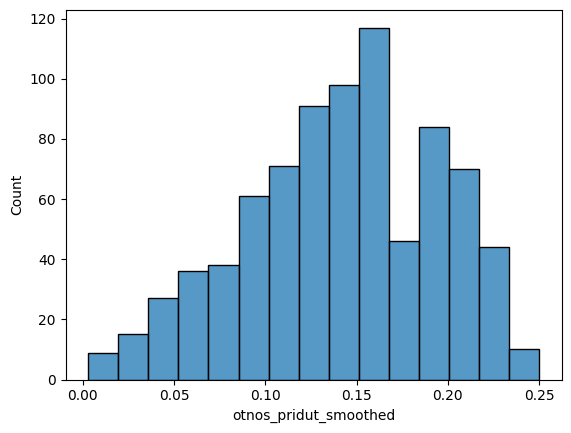

In [134]:
sns.histplot(num_col['otnos_pridut_smoothed'])

<Axes: xlabel='vsego_newbie', ylabel='Count'>

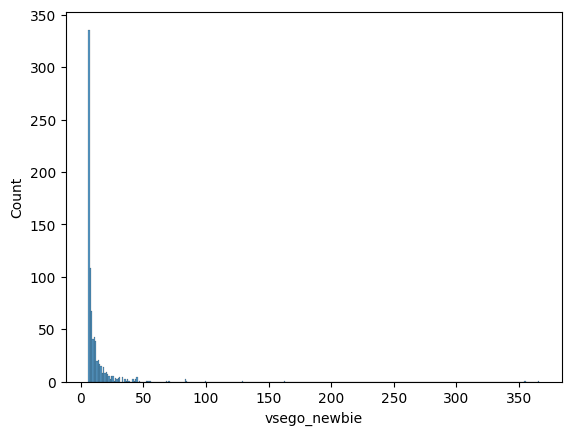

In [141]:
sns.histplot(num_col.vsego_newbie)

<Axes: xlabel='Разное', ylabel='otnos_pridut'>

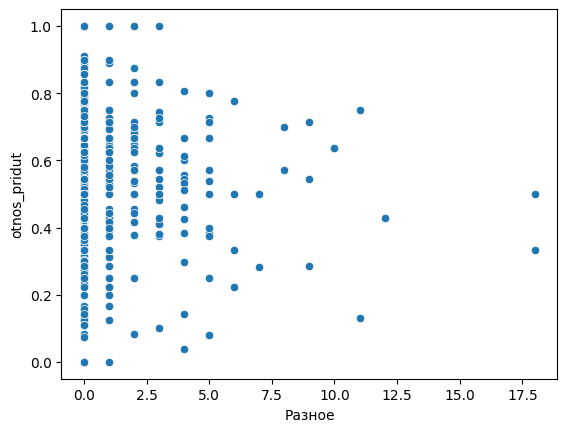

In [185]:
sns.scatterplot(y= num_col.otnos_pridut, x= num_col['Разное'])

In [167]:
num_col['otnos_pridut_smoothed'] = num_col['otnos_pridut_smoothed'] * 100

In [176]:
# Список колонок с количеством волонтеров
volunteer_columns = [
    'Маршал', 'Фотограф', 'Хранение и доставка оборудования', 'Подготовка мероприятия',
    'Связи с общественностью', 'Сканирование штрих-кодов', 'Секундомер', 'Обработка результатов',
    'Замыкающий', 'Сортировка карточек', 'Разное', 'Проверка трассы'
]

# Создание новых колонок has_(имя_волонтера)
for col in volunteer_columns:
    new_col_name = f"has_{col}"
    num_col[f"{new_col_name}"] = (num_col[col] > 0).astype(int)

# Проверка результатов
print(num_col.head(5))


   pridut  ne_pridut  vsego_newbie   mean_age  mean_gender  cnt_runners  \
0       9          7            16  40.500000     0.500000           81   
1       5          4             9  41.555556     0.444444           20   
2       4          2             6  34.666667     0.500000           15   
3       6          1             7  43.571429     0.428571           22   
4       4          2             6  39.500000     0.500000           26   

   discomfort_index  Ведущий велосипед  Завершение мероприятия  Замыкающий  \
0           6.28660                  0                       0           1   
1           6.67771                  0                       0           1   
2          11.58912                  0                       1           1   
3           6.01066                  0                       0           1   
4           7.70362                  0                       0           1   

   Инструктаж новых участников  Координатор парковки  Координация волонтёров  \


<Axes: xlabel='has_Маршал', ylabel='Count'>

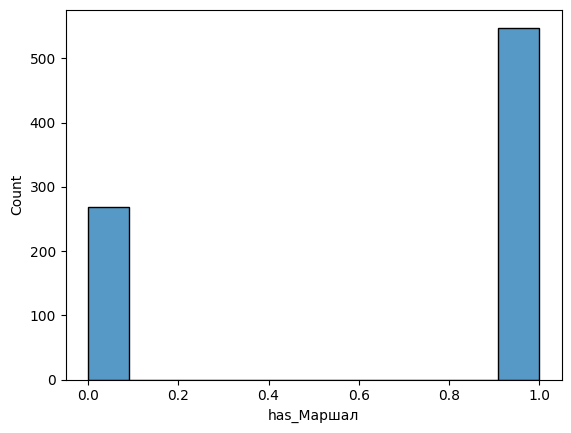

In [180]:
sns.histplot(num_col.has_Маршал)

In [188]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_pridut']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'Маршал', 'Фотограф', 'Хранение и доставка оборудования', 'Подготовка мероприятия', 'Связи с общественностью', 
                  'Сканирование штрих-кодов', 'Секундомер', 'Обработка результатов', 'Замыкающий', 'Сортировка карточек', 'Разное', 'Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = sm.OLS(y, x).fit()
# Печатаем результаты
print('0-50')
print(model.summary())


0-50
                            OLS Regression Results                            
Dep. Variable:           otnos_pridut   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.227
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           3.21e-07
Time:                        21:32:31   Log-Likelihood:                 131.42
No. Observations:                 803   AIC:                            -232.8
Df Residuals:                     788   BIC:                            -162.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
con

In [183]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_pridut_smoothed']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'has_Маршал', 'has_Фотограф', 'has_Хранение и доставка оборудования', 'has_Подготовка мероприятия', 'has_Связи с общественностью', 
                  'has_Сканирование штрих-кодов', 'has_Секундомер', 'has_Обработка результатов', 'has_Замыкающий', 'has_Сортировка карточек', 'has_Разное', 'has_Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = sm.OLS(y, x).fit()
# Печатаем результаты
print('0-50')
print(model.summary())

0-50
                              OLS Regression Results                             
Dep. Variable:     otnos_pridut_smoothed   R-squared:                       0.130
Model:                               OLS   Adj. R-squared:                  0.115
Method:                    Least Squares   F-statistic:                     8.437
Date:                   Sun, 08 Dec 2024   Prob (F-statistic):           3.76e-17
Time:                           21:25:34   Log-Likelihood:                -2380.0
No. Observations:                    803   AIC:                             4790.
Df Residuals:                        788   BIC:                             4860.
Df Model:                             14                                         
Covariance Type:               nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

In [189]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_ne_pridut']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'Маршал', 'Фотограф', 'Хранение и доставка оборудования', 'Подготовка мероприятия', 'Связи с общественностью', 
                  'Сканирование штрих-кодов', 'Секундомер', 'Обработка результатов', 'Замыкающий', 'Сортировка карточек', 'Разное', 'Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = sm.OLS(y, x).fit()
# Печатаем результаты
print('0-50')
print(model.summary())


0-50
                            OLS Regression Results                            
Dep. Variable:        otnos_ne_pridut   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     4.227
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           3.21e-07
Time:                        21:33:14   Log-Likelihood:                 131.42
No. Observations:                 803   AIC:                            -232.8
Df Residuals:                     788   BIC:                            -162.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
con

In [184]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_ne_pridut']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'has_Маршал', 'has_Фотограф', 'has_Хранение и доставка оборудования', 'has_Подготовка мероприятия', 'has_Связи с общественностью', 
                  'has_Сканирование штрих-кодов', 'has_Секундомер', 'has_Обработка результатов', 'has_Замыкающий', 'has_Сортировка карточек', 'has_Разное', 'has_Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = sm.OLS(y, x).fit()
# Печатаем результаты
print('0-50')
print(model.summary())

0-50
                            OLS Regression Results                            
Dep. Variable:        otnos_ne_pridut   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     4.277
Date:                Sun, 08 Dec 2024   Prob (F-statistic):           2.47e-07
Time:                        21:25:45   Log-Likelihood:                 131.75
No. Observations:                 803   AIC:                            -233.5
Df Residuals:                     788   BIC:                            -163.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [194]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_pridut']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'has_Маршал', 'has_Фотограф', 'has_Хранение и доставка оборудования', 'has_Подготовка мероприятия', 'has_Связи с общественностью', 
                  'has_Сканирование штрих-кодов', 'has_Секундомер', 'has_Обработка результатов', 'has_Замыкающий', 'has_Сортировка карточек', 'has_Разное', 'has_Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]
y = y.clip(0.01, 0.99)

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = GLM(y, x, family=Binomial()).fit()
# Печатаем результаты
print('0-50')
print(model.summary())

0-50
                 Generalized Linear Model Regression Results                  
Dep. Variable:           otnos_pridut   No. Observations:                  803
Model:                            GLM   Df Residuals:                      788
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -390.22
Date:                Sun, 08 Dec 2024   Deviance:                       152.72
Time:                        21:37:02   Pearson chi2:                     137.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01286
Covariance Type:            nonrobust                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [196]:
# Фильтруем данные и выравниваем индексы
y = num_col[num_col['vsego_newbie'] <= 50]['otnos_pridut']
x = num_col.drop(columns=['otnos_ne_pridut', 'otnos_pridut', 'otnos_pridut_smoothed', 'cnt_runners', 'pridut', 'ne_pridut', 'vsego_newbie', 'cnt_volunteers'])
needed_columns = ['discomfort_index', 'mean_age', 'Маршал', 'Фотограф', 'Хранение и доставка оборудования', 'Подготовка мероприятия', 'Связи с общественностью', 
                  'Сканирование штрих-кодов', 'Секундомер', 'Обработка результатов', 'Замыкающий', 'Сортировка карточек', 'Разное', 'Проверка трассы']
x = x[needed_columns]
# Убедитесь, что индексы совпадают
x = x.loc[y.index]

# Добавляем константу для модели
x = sm.add_constant(x)

# Обучаем модель
model = GLM(y, x, family=Binomial()).fit()
# Печатаем результаты
print('0-50')
print(model.summary())


0-50
                 Generalized Linear Model Regression Results                  
Dep. Variable:           otnos_pridut   No. Observations:                  803
Model:                            GLM   Df Residuals:                      788
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -390.56
Date:                Sun, 08 Dec 2024   Deviance:                       156.35
Time:                        21:40:30   Pearson chi2:                     138.
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01275
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
con

Text(0, 0.5, 'кол-во всего бегунов на пробежке')

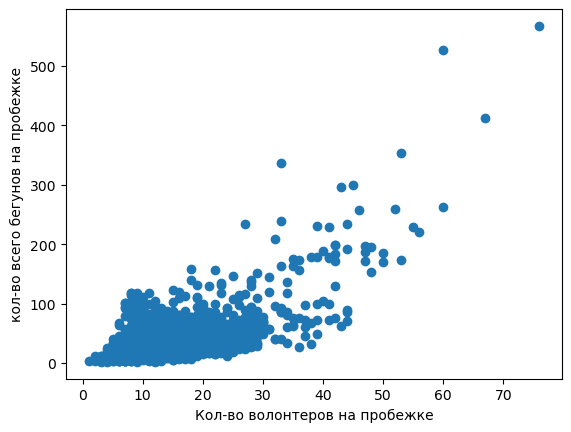

In [200]:
plt.scatter(x=info_about_jogging.cnt_volunteers, y=info_about_jogging.cnt_runners)
plt.xlabel('Кол-во волонтеров на пробежке')
plt.ylabel('кол-во всего бегунов на пробежке')


<Axes: xlabel='discomfort_index', ylabel='Count'>

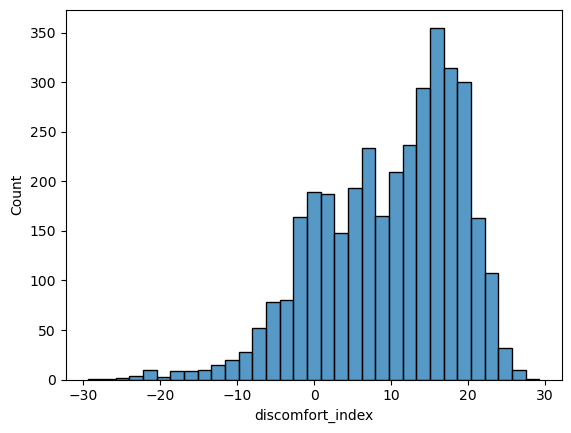

In [201]:
sns.histplot(x=info_about_jogging.discomfort_index)

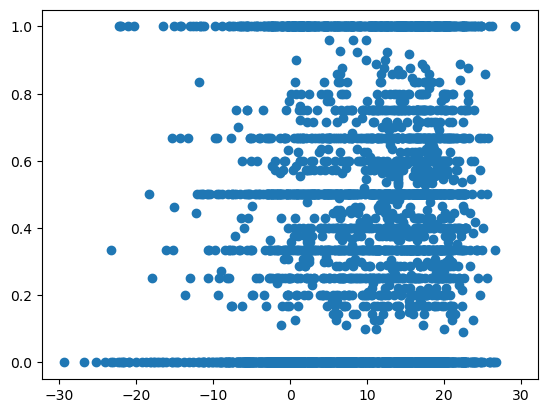

In [202]:
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.otnos_ne_pridut)


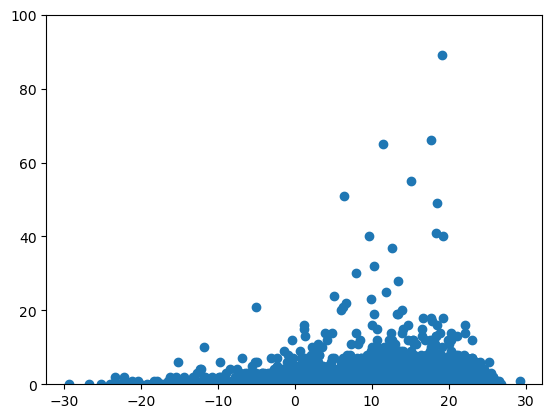

In [203]:
plt.ylim(0, 100)
plt.scatter(x=info_about_jogging.discomfort_index, y=info_about_jogging.ne_pridut)


<Axes: title={'center': 'распред финиш тайм для новичков которые придут во 2 раз'}, xlabel='finish_time', ylabel='Count'>

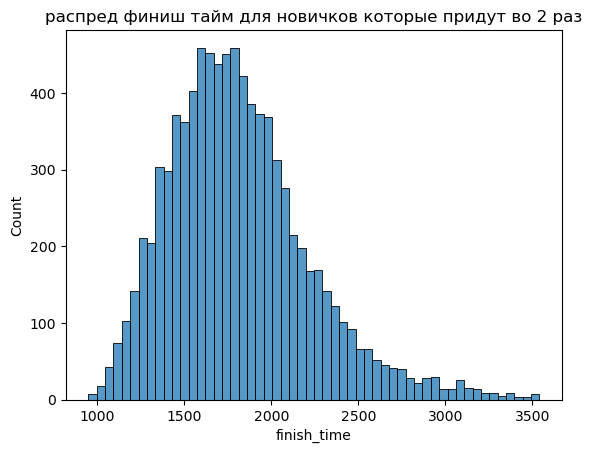

In [204]:
plt.title('распред финиш тайм для новичков которые придут во 2 раз')
sns.histplot(first_runs[first_runs.is_repeated==1].finish_time)

<Axes: title={'center': 'распред финиш тайм для новичков которые НЕ придут больше'}, xlabel='finish_time', ylabel='Count'>

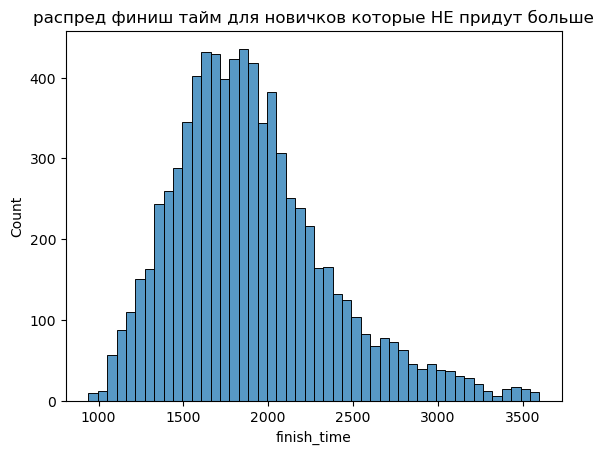

In [205]:
plt.title('распред финиш тайм для новичков которые НЕ придут больше')
sns.histplot(first_runs[first_runs.is_repeated==0].finish_time)

In [206]:
stat, p_value = stats.mannwhitneyu(first_runs[first_runs.is_repeated==0].finish_time, first_runs[first_runs.is_repeated==1].finish_time)  

# Выводим результаты  
print(f'Statistic: {stat}, p-value: {p_value}')  
print(first_runs[first_runs.is_repeated==1].finish_time.mean(), first_runs[first_runs.is_repeated==0].finish_time.mean())
# Интерпретируем результаты  
alpha = 0.05  
if p_value < alpha:  
    print('Отвергаем нулевую гипотезу: средние выборок статистически различаются.')  
else:  
    print('Не удалось отвергнуть нулевую гипотезу: средние выборок не различаются.')  

Statistic: 37436873.0, p-value: 2.7353233125906573e-31
1813.055753945398 1899.2434994235941
Отвергаем нулевую гипотезу: средние выборок статистически различаются.


D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

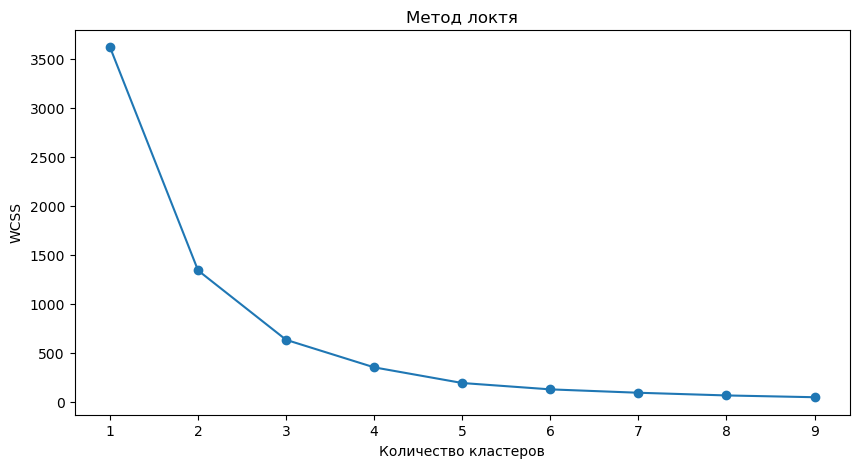

D:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   cluster  cnt_volunteers  vsego_newbie   ne_pridut
0        0       18.466102     13.021186    6.317797
1        1       12.007780      1.798627    0.696568
2        2       68.000000    356.000000  335.000000
3        3       30.981481     31.851852   15.888889
4        4       35.000000     88.875000   55.625000
5        5       14.632133      5.568042    2.476734


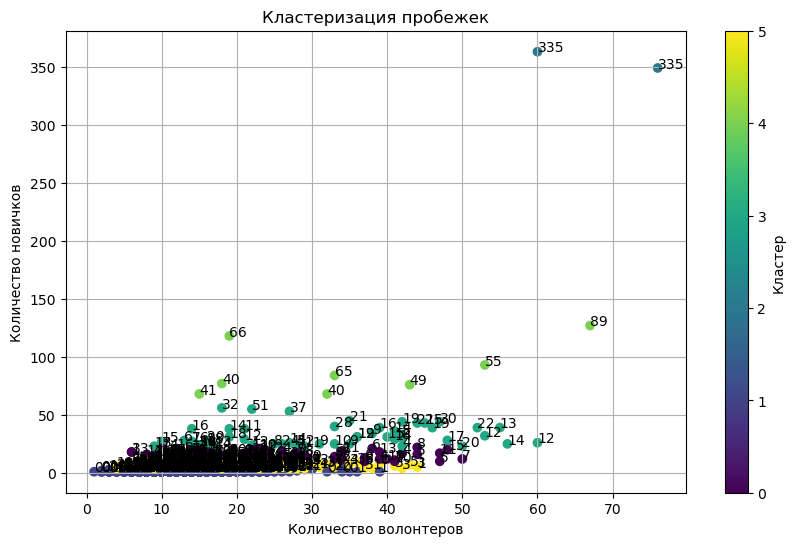

In [207]:
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler


# 2. Подготовьте данные для кластеризации  
X = info_about_jogging[['vsego_newbie']].values  

# Стандартизация данных (это важно для K-Means)  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  

# 3. Выбор количества кластеров  
# Один из способов - это метод локтя, когда мы просматриваем сумму квадратов расстояний:  
wcss = []  
for i in range(1, 10):  
    kmeans = KMeans(n_clusters=i, random_state=0)  
    kmeans.fit(X_scaled)  
    wcss.append(kmeans.inertia_)  

# Визуализируйте метод локтя  
plt.figure(figsize=(10, 5))  
plt.plot(range(1, 10), wcss, marker='o')  
plt.title('Метод локтя')  
plt.xlabel('Количество кластеров')  
plt.ylabel('WCSS')  
plt.show()  

# Выберите количество кластеров (например, 3 на основе метода локтя)  
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)  
info_about_jogging['cluster'] = kmeans.fit_predict(X_scaled)  

# 4. Анализ  
# Сравните средние значения в группах  
grouped = info_about_jogging.groupby('cluster').agg({  
    'cnt_volunteers': 'mean',  
    'vsego_newbie': 'mean',  
    'ne_pridut': 'mean'  
}).reset_index()  

print(grouped)  

# 5. Визуализация кластеров  
plt.figure(figsize=(10, 6))  
plt.scatter(info_about_jogging['cnt_volunteers'], info_about_jogging['vsego_newbie'],   
            c=info_about_jogging['cluster'], cmap='viridis', marker='o')  
plt.title('Кластеризация пробежек')  
plt.xlabel('Количество волонтеров')  
plt.ylabel('Количество новичков')  
plt.colorbar(label='Кластер')  
plt.grid(True)  

# Показать численность новичков, которые не придут на второй раз  
for idx, row in info_about_jogging.iterrows():  
    plt.annotate(f"{row['ne_pridut']}", (row['cnt_volunteers'], row['vsego_newbie']), fontsize=10)  

plt.show()

In [257]:
clst0 = info_about_jogging[(info_about_jogging.cluster == 1) & (info_about_jogging.event_date >= '2023-05-01') & (info_about_jogging.event_date <= '2023-10-01')]

y = clst0['ne_pridut']
x = clst0[['cnt_volunteers', 'discomfort_index', 'mean_age', 'mean_gender']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())
display(clst0.ne_pridut.describe())
print(clst0.cnt_volunteers.describe())

                            OLS Regression Results                            
Dep. Variable:              ne_pridut   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     6.346
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           4.80e-05
Time:                        21:44:05   Log-Likelihood:                -1209.2
No. Observations:                1037   AIC:                             2428.
Df Residuals:                    1032   BIC:                             2453.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9812      0.170  

count    1037.000000
mean        0.788814
std         0.786438
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: ne_pridut, dtype: float64

count    1037.000000
mean       11.840887
std         4.586444
min         2.000000
25%         9.000000
50%        11.000000
75%        14.000000
max        36.000000
Name: cnt_volunteers, dtype: float64
